In [316]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import f_oneway, shapiro, levene, kruskal, ttest_ind

from python.mappings import FOOTBALL_LEAGUES_MAPPING, TEAMS_RANKING_MAPPING

%matplotlib inline

# Drop: 'side_12', 'side_13', 'side_21', 'side_22', 'side_23', 'position_1' (? - еще надо проверить), 'position_2' (? - еще надо проверить), 'position_2_sides', 'league' (?)
# Create: 'premier_league?'

In [317]:
# Constant variables
TABLE_SIZE = 1546
TRAIN_RATIO = 0.8

In [318]:
# Joins train and test datasets together to simplify the process
def concat_df(df1, df2):
    return pd.concat([df1, df2], ignore_index=True)

# Divides the overall dataset into train and test 
def divide_df(df):
    train_size = int(TABLE_SIZE*TRAIN_RATIO)
    
    return df.loc[:train_size - 1], df.loc[train_size:] 

In [319]:
train_data = pd.read_csv('data/train_stats.csv')
test_data = pd.read_csv('data/test_stats.csv')
all_data = concat_df(train_data, test_data)

**1. PREPARATION STEP: Cleaning the data**

In [320]:
all_data.drop(['Player_URL', 'Team_URL'], axis=1, inplace=True)

In [321]:
# Cleans the columns containing commas 
def clean_comma(column):
    column = column.strip()
    column = column[:column.find(',')] + '' + column[column.find(',') + 1:]
    return column

# Cleans the columns containing '\t' symbol
def clean_tab(column):
    return column.strip().replace('\t', '')

In [322]:
comma_columns = ['Team', 'Position']
tab_columns = ['Goals', 'Assists', 'Yel', 'Red', 'SpG', 'AerialsWon', 'MotM', 'Tackles',
               'Inter', 'Fouls', 'Offsides', 'Clear', 'Drb_x', 'Blocks', 'OwnG', 'KeyP',
               'Drb_y', 'Fouled', 'Off', 'Disp', 'UnsTch', 'Crosses', 'LongB', 'ThrB']

for column in comma_columns:
    all_data[column] = all_data[column].apply(clean_comma)
    
for column in tab_columns:
    all_data[column] = all_data[column].apply(clean_tab)

In [323]:
# Some columns with integer values contain symbol '-' instead of 0. The function fixes it
def remove_dashes(column):
    if column == '-':
        return 0
    return column

In [324]:
dash_columns = ['Goals', 'Assists', 'Yel', 'Red', 'SpG', 'AerialsWon', 'MotM', 'Tackles',
                'Inter', 'Fouls', 'Offsides', 'Clear', 'Drb_x', 'Drb_y', 'Blocks', 'OwnG', 'KeyP',
                'Fouled', 'Off', 'Disp', 'UnsTch', 'Crosses', 'LongB', 'ThrB']

for column in dash_columns:
    all_data[column] = all_data[column].apply(remove_dashes)

In [325]:
# Now we have 'Value' variable containing market values in thousands or millions, but we want to get just an integer
def value_scaling(value):
    value = value.strip()
    
    if value.endswith('k'):
        return int(float(value[value.find('€')+1:value.find('k')]) * 10**3)
    elif value.endswith('m'):
        return int(float(value[value.find('€')+1:value.find('m')]) * 10**6)

In [326]:
all_data['Value'] = all_data['Value'].apply(value_scaling)

In [327]:
# We can divide 'Apps' variable because the number of appearances in starting squad is demonstrated in parentheses 
def appearances_division(apps):
    return apps[:apps.find('(')], apps[apps.find('(')+1:apps.find(')')]

In [328]:
all_data['Overall_Apps'], all_data['Start_Apps'] = zip(*all_data['Apps'].apply(appearances_division))

In [329]:
all_data.drop(['Apps'], axis=1, inplace=True)

In [330]:
# It would be better if we replace 'Forward', 'Midfielder' with their short forms (FW, M)

#all_data['Position'].value_counts()

def position_mapping(position):
    position = position.strip()
    
    if position == 'Forward': 
        return 'FW'
    elif position == 'Midfielder': 
        return 'M(C)'
    return position

all_data['Position'] = all_data['Position'].apply(position_mapping)

In [331]:
# We can divide 'Position' column into two positions (if some player has only one position, he`ll get NaN value for the second one).
def position_division(position):
    
    # only two main positions, that`s enough
    if position.count(',') >= 2:
        while position.count(',') != 1:
            position = position[:position.rfind(',')]
          
    if position.find(',') != -1:
        return pd.Series([position[:position.find(',')].strip(), position[position.find(',')+1:]]).values
    return pd.Series([position.strip(), np.nan]).values

# Center (C), Right (R) or Left (L)? This information is contained in parentheses
def position_side(position):
    
    # np.nan has 'float' type
    if type(position) != float:
        if position.find('(') != -1:
            sides = tuple(position[position.find('(')+1:position.find(')')])
            position = position[:position.find('(')].strip(),
            
            return position + sides + tuple([np.nan] * (3 - len(sides)))
        else:
            position = position.strip(),

            return position + tuple([np.nan] * 3)
    else:
        return tuple([np.nan] * 4)

In [332]:
all_data['Position_1'], all_data['Position_2'] = zip(*all_data['Position'].apply(position_division))

In [333]:
all_data['Position_1'], all_data['Side_11'], all_data['Side_12'], all_data['Side_13'] = zip(*all_data['Position_1'].apply(position_side))
all_data['Position_2'], all_data['Side_21'], all_data['Side_22'], all_data['Side_23'] = zip(*all_data['Position_2'].apply(position_side))

In [334]:
all_data.drop(['Position'], axis=1, inplace=True)

In [335]:
# Time to change column types
float_type = ['SpG', 'AerialsWon', 'Tackles', 'Inter', 'Fouls', 'Offsides',
              'Clear', 'Drb_x', 'Blocks', 'KeyP', 'Drb_y', 'Fouled', 'Off',
              'Disp', 'UnsTch', 'Crosses', 'LongB', 'ThrB']
int_type = ['Goals', 'Assists', 'Yel', 'Red', 'MotM', 'OwnG', 'Overall_Apps', 'Start_Apps']

all_data[float_type] = all_data[float_type].astype('float')
all_data[int_type] = all_data[int_type].astype('int64')

In [336]:
# Insert 'Value' variable at the end of the dataset
value_column = all_data.pop('Value')
all_data['Value'] = value_column

# Insert 'Position_2' variable before the variable 'Side_21'
pos2_column = all_data.pop('Position_2')
index = all_data.columns.get_loc('Side_21')
all_data.insert(index, 'Position_2', pos2_column)

**2. EXPLORATORY DATA ANALYSIS AND FEATURE ENGINEERING**

**GLOSSARY. DESCRIPTION OF THE VARIABLES**

- SpG - Shots per game
- PS(%) - Percentage of successful passes
- AerialsWon, Aerial - Header in a direct contest with an opponent
- MotM - Man of the Match
- Tackle - Dispossessing an opponent, whether the tackling player comes away with the ball or not
- Interception (Inter) - Preventing an opponent's pass from reaching their teammates
- Fouls - How often a player commits a foul
  Fouled - How often a player gets fouled
- Offsides - It`s referred to "offside won" - the last man to step up to catch an opponent in an offside position
  Off - How often a player gets in offside position
- Clearance (Clear) - Action by a defending player that temporarily removes the attacking threat on their goal/that effectively alleviate pressure on their goal
- Drb_x - How often a player gets dribbled (being dribbled past by an opponent without winning a tackle)
  Drb_y - Frequency of successful dribbles
- Blocks - The number of blocked shots per game
- OwnG - Own goal
- KeyP - Key passes (the final pass leading to a shot at goal from a teammate)
- Dispossessed (Disp) - How often a player gets tackled by an opponent without attempting to dribble past them
- UnsTch - ???
- Average Passes (AvgP) - Average number of passes attempted (short passes, long balls, through balls, crosses)
- Cross - An attempted/accurate pass from a wide position to a central attacking area
- Long Ball (LongB) - An attempted/accurate pass of 25 yards or more
- Through Ball (ThrB) - An attempted/accurate pass between opposition players in their defensive line to find an onrushing teammate (running through on goal)
- Apps - appearances on the football field

In [337]:
#all_data.info()

Let`s start with categorical variables.

We see that there are a lot of missing values for 'Side_2X' and 'Side_13' variables (>80%). It describes where a player is located on a football pinch (left, right or center). But it can be useful to create a variable that shows how much place some player "occupies", on how many sides he is able to play. If it isn`t shown (all three variables are NaN values), then we will set 1.

In [338]:
def position_sides(s1, s2, s3):
    sides_list = [s1, s2, s3]
    
    while np.nan in sides_list:
        sides_list.remove(np.nan)
    
    if len(sides_list) == 0:
        return 1
    return len(sides_list)

In [339]:
all_data['Position_1_Sides'] = all_data.apply(lambda x: position_sides(x['Side_11'], x['Side_12'], x['Side_13']), axis=1)
all_data['Position_2_Sides'] = all_data.apply(lambda x: position_sides(x['Side_21'], x['Side_22'], x['Side_23']), axis=1)

Other variables have no missing values so we can continue in our research

'Team' variable can be very useful: we can extract a league in which a football player competes, and it is somehow influences his market value. For instance, we expect that in Premier League players cost more because of higher level of this championship and some other aspects. For this task we will use our mapping.

Also, we can divide our teams into three groups (A, B, C) based on their level ranking. Perhaps, players from "big teams" are more expensive 

In [340]:
all_data['League'] = all_data['Team'].map(FOOTBALL_LEAGUES_MAPPING)
all_data['Team_rank'] = all_data['Team'].map(TEAMS_RANKING_MAPPING)

Let`s check our presumptions by creating some plots!

In [341]:
order_rank = ['A-tier', 'B-tier', 'C-tier']

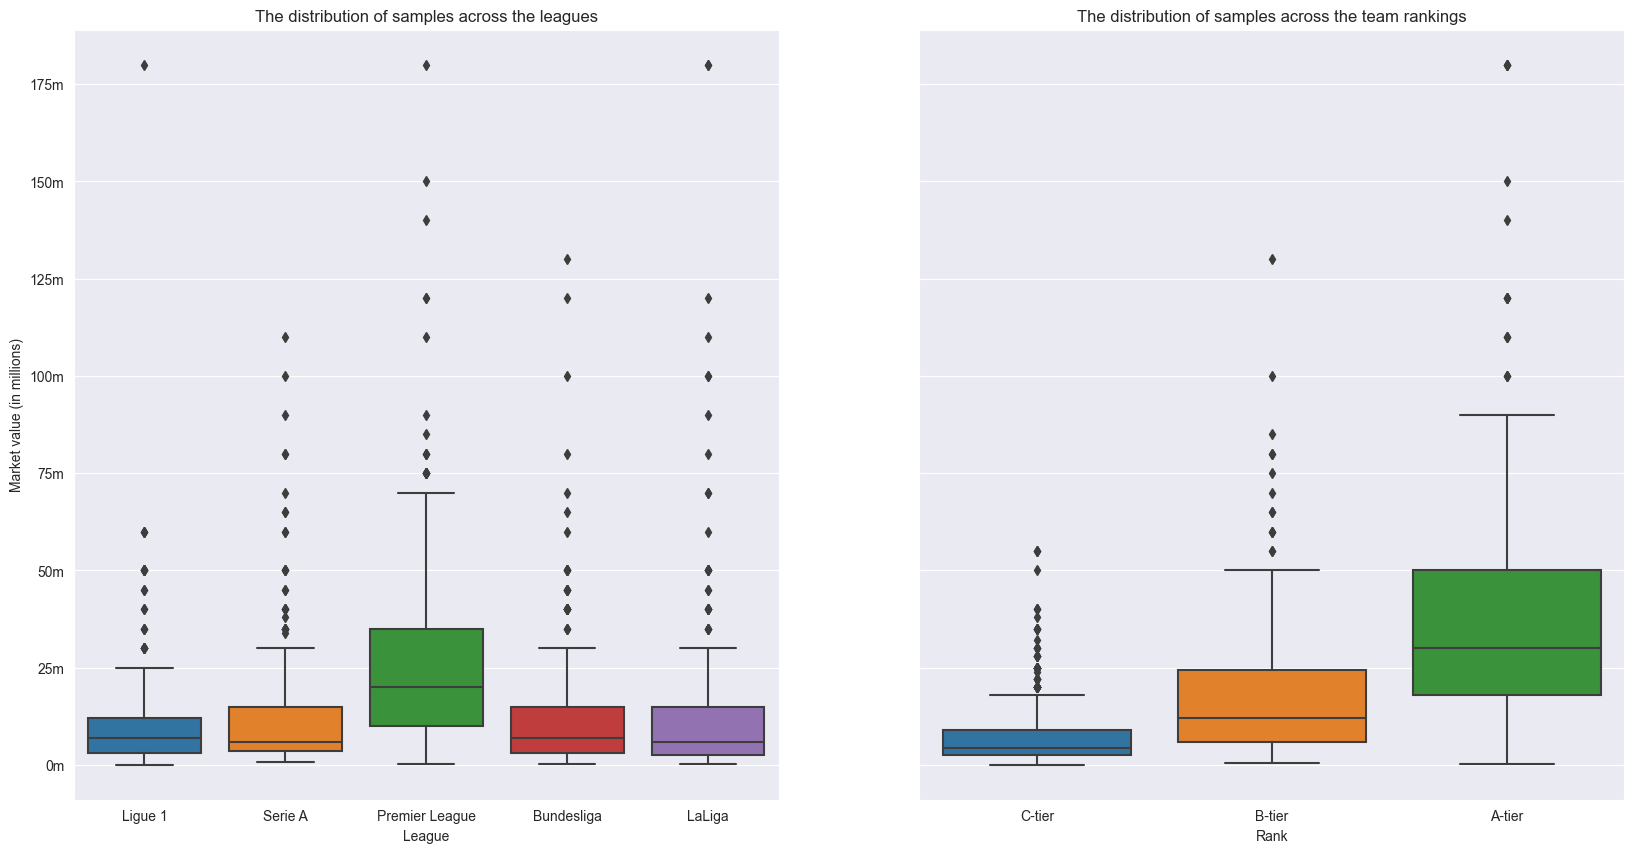

In [342]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

sns.boxplot(all_data,
            x='League',
            y='Value',
            ax=ax[0])

sns.boxplot(all_data,
            x='Team_rank',
            y='Value',
            order=reversed(order_rank),
            ax=ax[1])

ax[0].set_title('The distribution of samples across the leagues')
ax[0].set_yticks(ticks=[0, 0.25e8, 0.5e8, 0.75e8, 1e8, 1.25e8, 1.5e8, 1.75e8], 
                 labels=['0m', '25m', '50m', '75m', '100m', '125m', '150m', '175m'])
ax[0].set_ylabel('Market value (in millions)')

ax[1].set_title('The distribution of samples across the team rankings')
ax[1].set_xlabel('Rank')
ax[1].set_ylabel('')

plt.show()

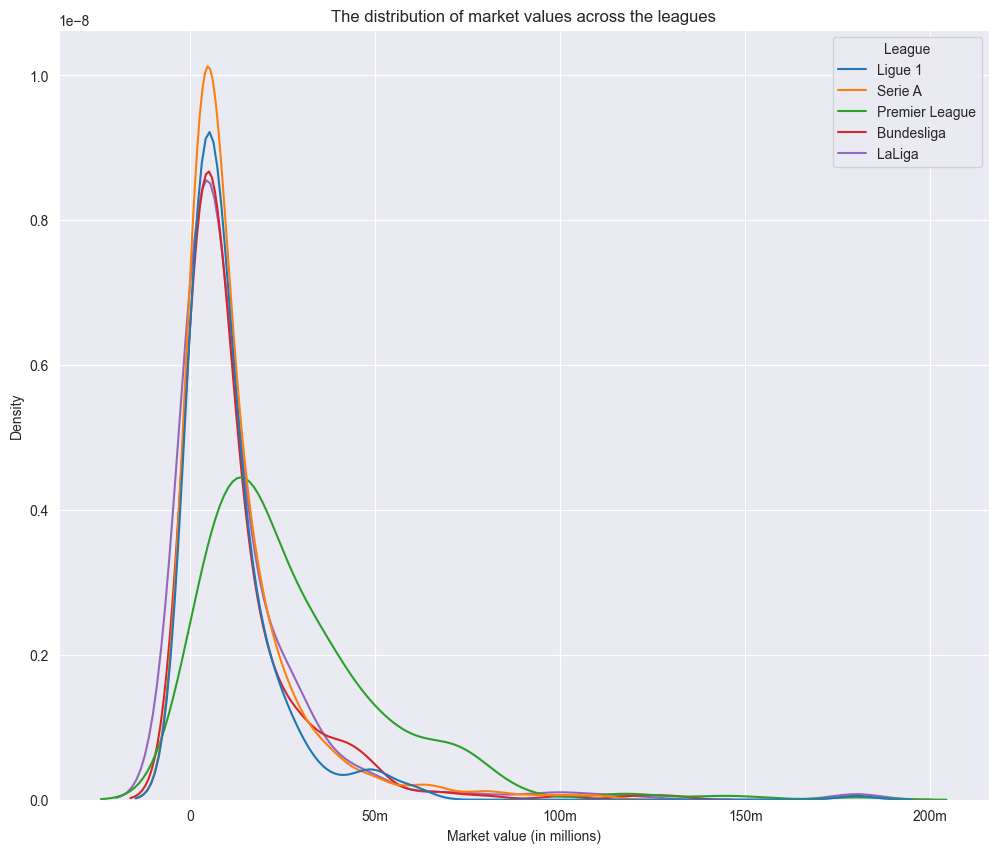

In [343]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.kdeplot(all_data,
            x='Value',
            hue='League')

ax.set_title('The distribution of market values across the leagues')
ax.set_xlabel('Market value (in millions)')
ax.set_xticks(ticks=[0, 0.5e8, 1e8, 1.5e8, 2e8], labels=['0', '50m', '100m', '150m', '200m'])

plt.show()

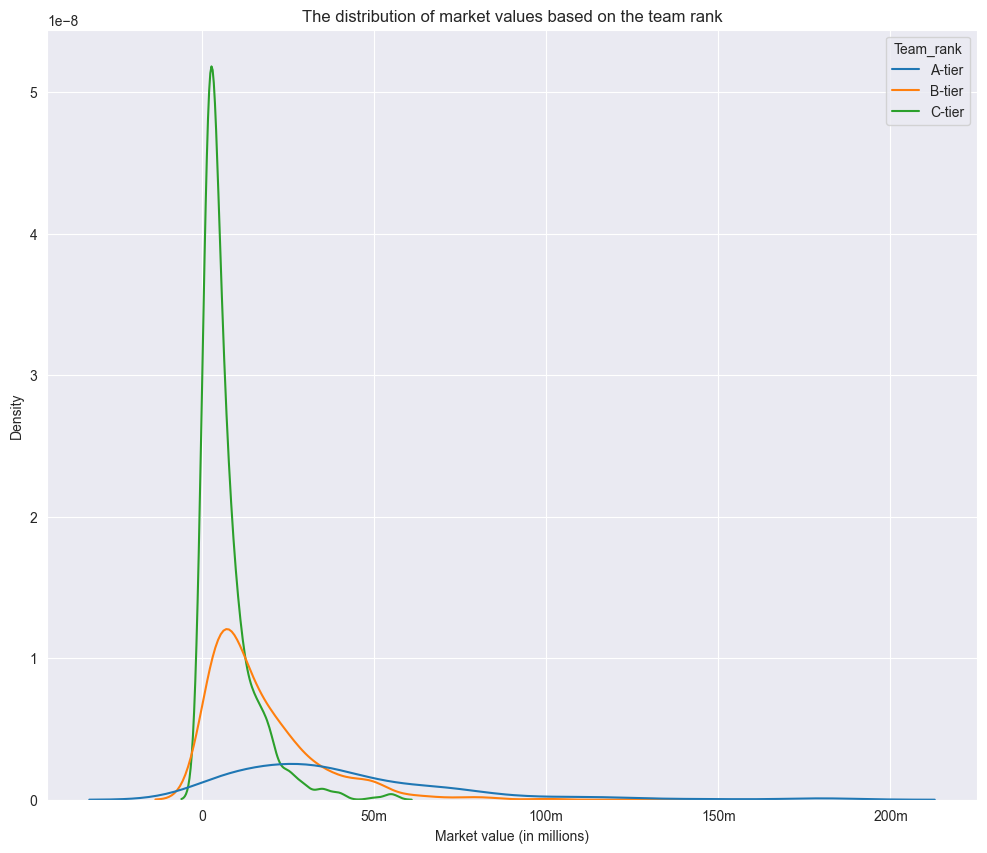

In [344]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.kdeplot(all_data,
            x='Value',
            hue='Team_rank',
            hue_order=order_rank)

ax.set_title('The distribution of market values based on the team rank')
ax.set_xlabel('Market value (in millions)')
ax.set_xticks(ticks=[0, 0.5e8, 1e8, 1.5e8, 2e8], labels=['0', '50m', '100m', '150m', '200m'])

plt.show()

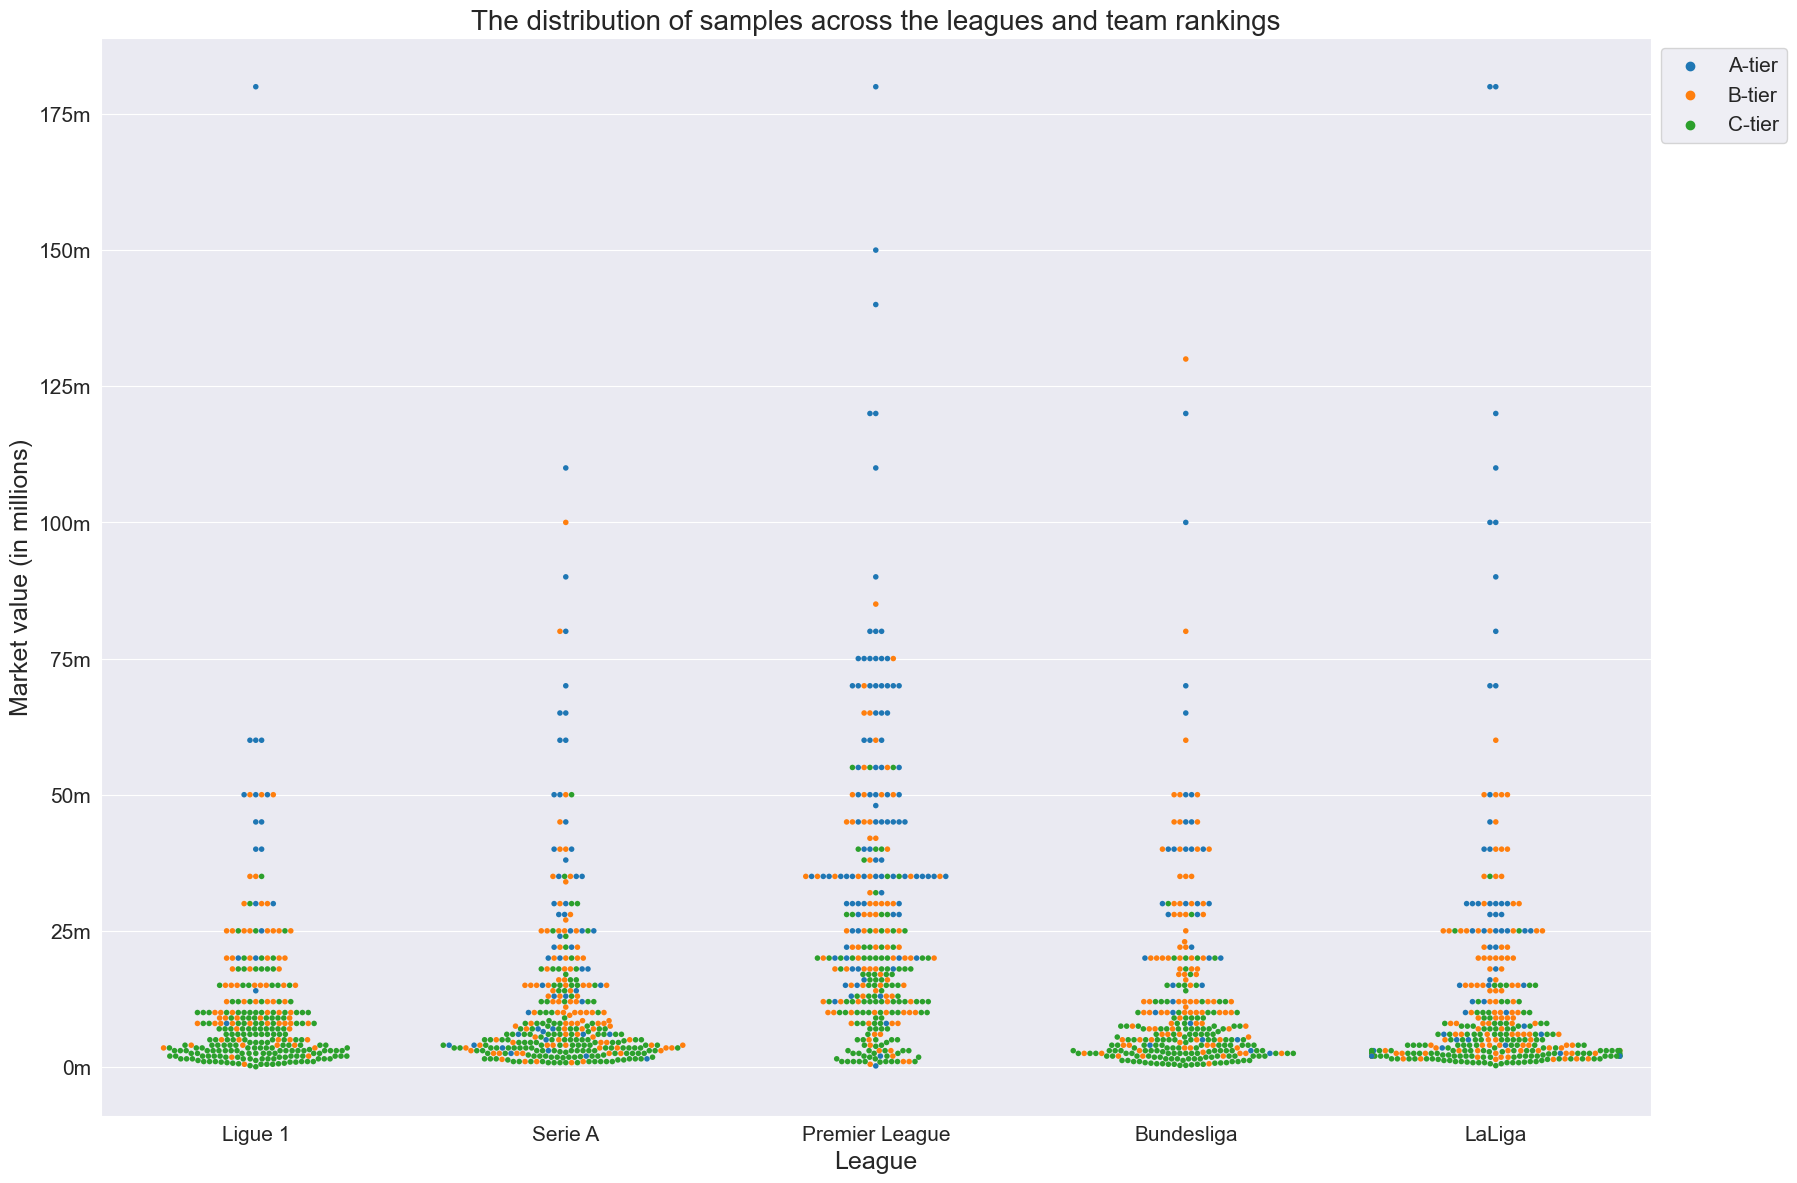

In [345]:
fig, ax = plt.subplots(figsize=(20, 14))

sns.swarmplot(all_data,
              x='League',
              y='Value',
              size=4,
              hue='Team_rank',
              hue_order=order_rank,
              ax=ax)

ax.set_title('The distribution of samples across the leagues and team rankings', fontsize=20)
ax.set_yticks(ticks=[0, 0.25e8, 0.5e8, 0.75e8, 1e8, 1.25e8, 1.5e8, 1.75e8], 
                 labels=['0m', '25m', '50m', '75m', '100m', '125m', '150m', '175m'])
ax.set_ylabel('Market value (in millions)', fontsize=18)
ax.xaxis.label.set_size(18)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(bbox_to_anchor=(1, 1), loc=2, fontsize=15)

plt.show()

On the first graph we can see that the distributions are almost the same across the leagues, but the Premier league has a little bit different one with higher market values than for other leagues.

From the second one we can notice that the distributions for A-ranked and B-ranked clubs are more heavy-tailed than for C-ranked teams, and in general, the majority of players in "small clubs" are located on the left part of the graph.

In [346]:
# Creates a table with different descriptive statistics for different groups of a categorical variable 
def descriptive_table(variable):
    indices=all_data.groupby(variable)['Value'].mean().index
    counts = all_data.groupby(variable)['Value'].count().values
    means = all_data.groupby(variable)['Value'].mean().values
    stds = all_data.groupby(variable)['Value'].std().values
    medians = all_data.groupby(variable)['Value'].median().values
    quantile_ninty = all_data.groupby(variable)['Value'].quantile(q=0.9).values
    
    table =  pd.DataFrame({'Sample size': counts,
                           'Mean': means,
                           'St. deviation': stds,
                           'Median': medians,
                           '90% quantile': quantile_ninty
                           }, index=indices)
    return table    

In [347]:
for item in ['League', 'Team_rank']:
    print(f"Variable: {item}")
    display(descriptive_table(item))

Variable: League


,Sample size,Mean,St. deviation,Median,90% quantile
League,,,,,
Bundesliga,296,1.282111e+07,1.714876e+07,7000000.0,30000000.0
LaLiga,329,1.309073e+07,2.152709e+07,6000000.0,30000000.0
Ligue 1,284,1.107042e+07,1.529310e+07,7000000.0,25000000.0
Premier League,314,2.796656e+07,2.559655e+07,20000000.0,63500000.0
Serie A,323,1.243467e+07,1.585947e+07,6000000.0,29600000.0


Variable: Team_rank


,Sample size,Mean,St. deviation,Median,90% quantile
Team_rank,,,,,
A-tier,252,3.962778e+07,3.309946e+07,30000000.0,75000000.0
B-tier,490,1.708265e+07,1.607032e+07,12000000.0,40000000.0
C-tier,804,7.073507e+06,7.581229e+06,4250000.0,17000000.0


**Idea**: We can create a variable that indicates whether some footballer plays in Premier League instead of 'League' column

Now we will work with positions. It can be very useful to divide player`s positions into four groups (attack, midfield, defence and goalkeeper) because we can expect that the players in attack line cost more than goalkeepers. We will only operate with the main position and create 'Position' column.

In [348]:
position_mapping = {'FW': 'Attack',
                    'AM': 'Midfield',
                    'M': 'Midfield',
                    'DMC': 'Midfield',
                    'D': 'Defence',
                    'GK': 'Goalkeeper'}

all_data['Position'] = all_data['Position_1'].map(position_mapping)

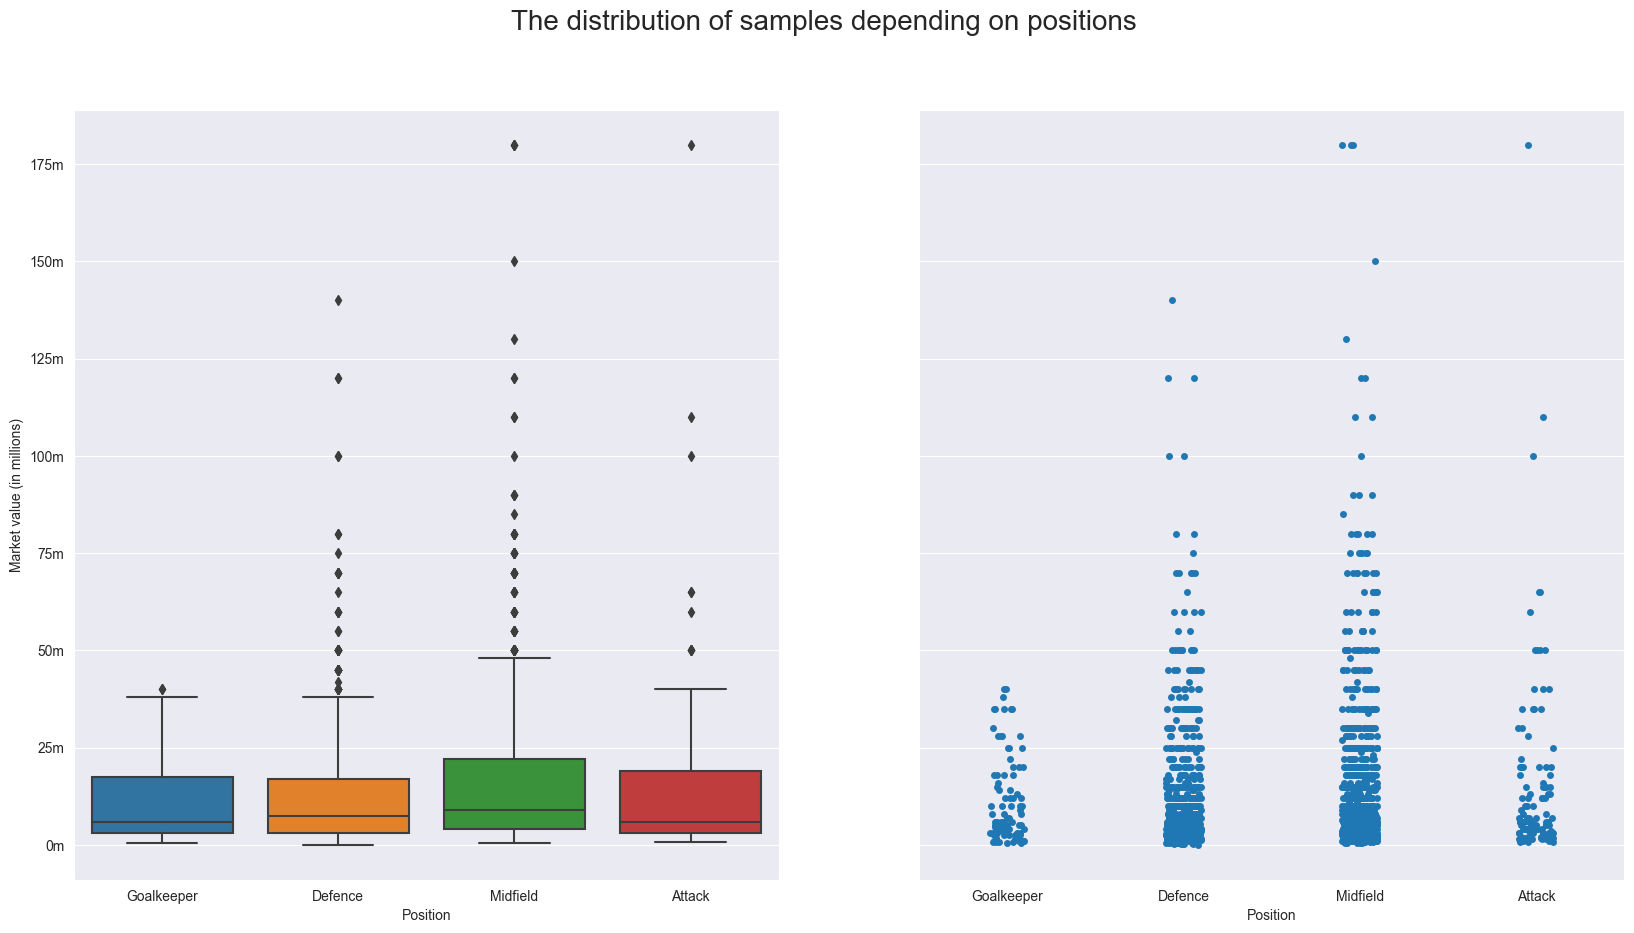

In [349]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

position_rank = ['Goalkeeper', 'Defence', 'Midfield', 'Attack']

sns.boxplot(all_data,
            x='Position',
            y='Value',
            order=position_rank,
            ax=ax[0])

sns.stripplot(all_data,
              x='Position',
              y='Value',
              order=position_rank,
              ax=ax[1])

fig.suptitle('The distribution of samples depending on positions', fontsize=20)
ax[0].set_yticks(ticks=[0, 0.25e8, 0.5e8, 0.75e8, 1e8, 1.25e8, 1.5e8, 1.75e8], 
                 labels=['0m', '25m', '50m', '75m', '100m', '125m', '150m', '175m'])
ax[0].set_ylabel('Market value (in millions)')

ax[1].set_ylabel('')

plt.show()

In [350]:
display(descriptive_table('Position'))

,Sample size,Mean,St. deviation,Median,90% quantile
Position,,,,,
Attack,111,1.616396e+07,2.488179e+07,6000000.0,40000000.0
Defence,618,1.359684e+07,1.715473e+07,7500000.0,35000000.0
Goalkeeper,94,1.108936e+07,1.100055e+07,6000000.0,28000000.0
Midfield,723,1.771003e+07,2.305809e+07,9000000.0,45000000.0


In [351]:
# Significance test for some categorical variable
def significance_test(variable, transformation=False, test_type=None):
    groups = []

    for group in all_data[variable].unique():
        sample = all_data.query(variable + '== @group')['Value'].values
        
        if transformation == 'log': 
            sample = np.log(sample + 1)
        elif transformation == 'sqrt': 
            sample = np.sqrt(np.abs(sample))
            
        print(f'Shapiro-Wilk test: {shapiro(sample)}')
        groups.append(sample)

    print(f'Levene: {levene(*groups)}')
    
    if test_type == 'anova':
        print(f'ANOVA test: {f_oneway(*groups)}')
    elif test_type == 'kruskal':
        for g in groups:
            np.sort(g)
            
        print(f'Kruskal-Wallis test: {kruskal(*groups)}')

In [352]:
significance_test('Position')

Shapiro-Wilk test: ShapiroResult(statistic=0.6761902859086902, pvalue=6.197708076654985e-35)
Shapiro-Wilk test: ShapiroResult(statistic=0.820127441024127, pvalue=2.441868285597932e-09)
Shapiro-Wilk test: ShapiroResult(statistic=0.5910474408709383, pvalue=4.2454838122298744e-16)
Shapiro-Wilk test: ShapiroResult(statistic=0.6923282909868966, pvalue=4.8918881744521404e-32)
Levene: LeveneResult(statistic=5.071962668203488, pvalue=0.001695870592367609)


The samples aren`t distributed normally and their variances differ significantly, but we can use transformations

In [353]:
for tr in ['log', 'sqrt']:
    significance_test('Position', transformation=tr)
    print()
    print('=' * 25)
    print()

Shapiro-Wilk test: ShapiroResult(statistic=0.9911483603510157, pvalue=0.00025009395067626433)
Shapiro-Wilk test: ShapiroResult(statistic=0.9638427394140349, pvalue=0.010609204782735901)
Shapiro-Wilk test: ShapiroResult(statistic=0.9810127009464324, pvalue=0.11544302038132292)
Shapiro-Wilk test: ShapiroResult(statistic=0.9908761008326488, pvalue=0.0007225419010297908)
Levene: LeveneResult(statistic=0.23173730875181117, pvalue=0.8743134437741662)


Shapiro-Wilk test: ShapiroResult(statistic=0.8978465520242858, pvalue=1.5981228275437358e-21)
Shapiro-Wilk test: ShapiroResult(statistic=0.9240363383959092, pvalue=3.984101043060345e-05)
Shapiro-Wilk test: ShapiroResult(statistic=0.8419662299523764, pvalue=1.5549967643470708e-09)
Shapiro-Wilk test: ShapiroResult(statistic=0.9034120742644598, pvalue=2.527130728362949e-19)
Levene: LeveneResult(statistic=3.6987904334092474, pvalue=0.01140466767212007)




The samples` distribution is still abnormal, but their variances are homogenous, so we can try to use Kruskal-Wallis test (we cannot use ANOVA test)

In [354]:
print('Without transformation: ')
significance_test('Position', transformation=False, test_type='kruskal')

Without transformation: 
Shapiro-Wilk test: ShapiroResult(statistic=0.6761902859086902, pvalue=6.197708076654985e-35)
Shapiro-Wilk test: ShapiroResult(statistic=0.820127441024127, pvalue=2.441868285597932e-09)
Shapiro-Wilk test: ShapiroResult(statistic=0.5910474408709383, pvalue=4.2454838122298744e-16)
Shapiro-Wilk test: ShapiroResult(statistic=0.6923282909868966, pvalue=4.8918881744521404e-32)
Levene: LeveneResult(statistic=5.071962668203488, pvalue=0.001695870592367609)
Kruskal-Wallis test: KruskalResult(statistic=15.038079641393859, pvalue=0.0017843947425119037)


In [355]:
print('With log transformation: ')
significance_test('Position', transformation='log', test_type='kruskal')

With log transformation: 
Shapiro-Wilk test: ShapiroResult(statistic=0.9911483603510157, pvalue=0.00025009395067626433)
Shapiro-Wilk test: ShapiroResult(statistic=0.9638427394140349, pvalue=0.010609204782735901)
Shapiro-Wilk test: ShapiroResult(statistic=0.9810127009464324, pvalue=0.11544302038132292)
Shapiro-Wilk test: ShapiroResult(statistic=0.9908761008326488, pvalue=0.0007225419010297908)
Levene: LeveneResult(statistic=0.23173730875181117, pvalue=0.8743134437741662)
Kruskal-Wallis test: KruskalResult(statistic=15.038079641393859, pvalue=0.0017843947425119037)


Since Kruskal-Wallis test shows significant result, we can leave this variable

Let`s check 'Side_11' variable because it is footballer's main side (location where he usually plays)

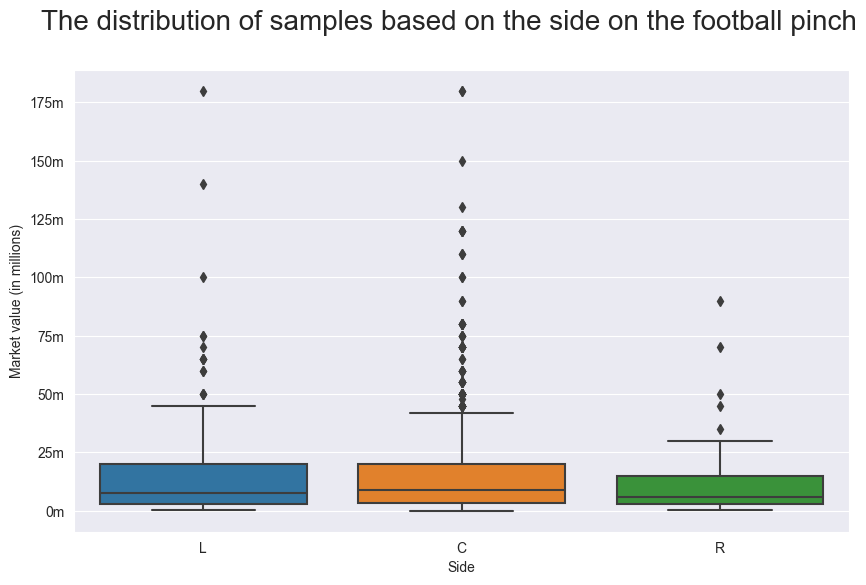

In [356]:
fig, ax = plt.subplots(figsize=(10, 6))

side_rank = ['L', 'C', 'R']

sns.boxplot(all_data,
            x='Side_11',
            y='Value',
            order=side_rank,
            ax=ax)

fig.suptitle('The distribution of samples based on the side on the football pinch', fontsize=20)
ax.set_yticks(ticks=[0, 0.25e8, 0.5e8, 0.75e8, 1e8, 1.25e8, 1.5e8, 1.75e8], 
                 labels=['0m', '25m', '50m', '75m', '100m', '125m', '150m', '175m'])
ax.set_ylabel('Market value (in millions)')
ax.set_xlabel('Side')

plt.show()

In [357]:
descriptive_table('Side_11')

,Sample size,Mean,St. deviation,Median,90% quantile
Side_11,,,,,
C,881,1.690159e+07,2.164405e+07,9000000.0,42000000.0
L,237,1.511181e+07,2.128865e+07,7500000.0,35000000.0
R,115,1.097565e+07,1.338361e+07,6000000.0,25000000.0


This variable is not so useful as the previous ones. There are too little data for Left and Right sides, and we can expect that 'Side_12', 'Side_13', etc. are even less informative, so in the future we can drop them, leaving only 'Main_side' (it is the same as 'Side_11') variable.

Now we will work with 'Position_1_Sides' and 'Position_2_Sides' and create some interesting (at least we hope) plots

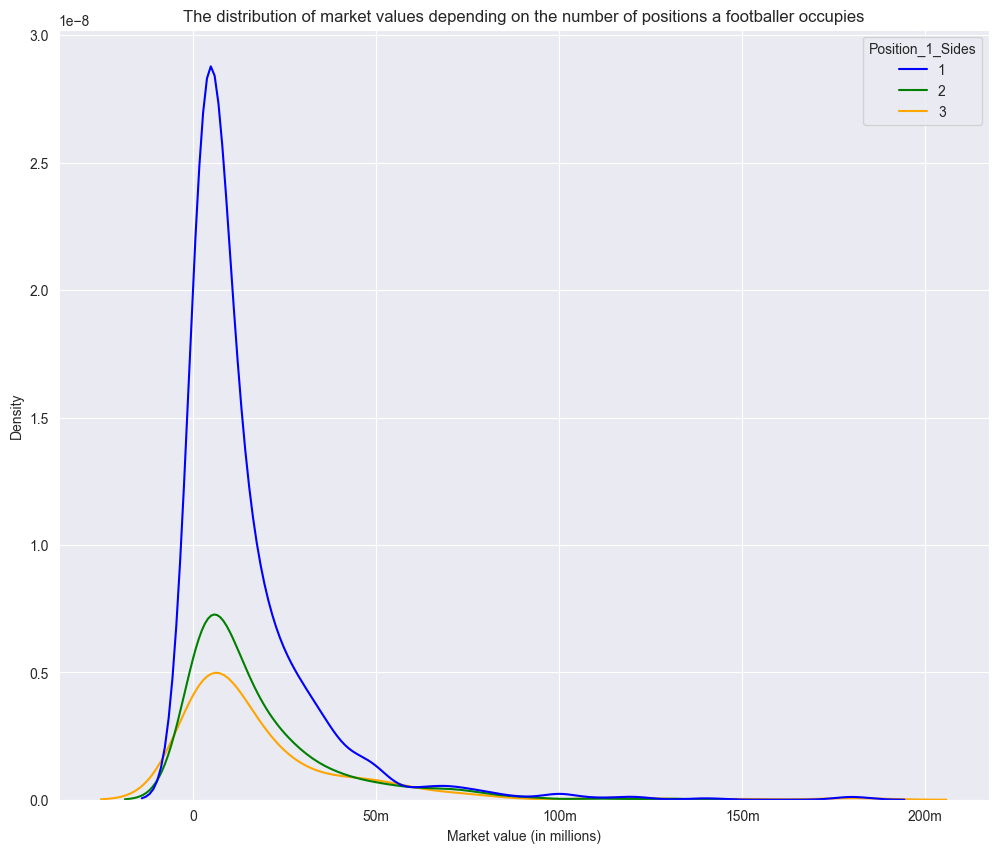

In [365]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.kdeplot(all_data,
            x='Value',
            hue='Position_1_Sides',
            palette=['blue', 'green', 'orange'])

ax.set_title('The distribution of market values depending on the number of positions a footballer occupies')
ax.set_xlabel('Market value (in millions)')
ax.set_xticks(ticks=[0, 0.5e8, 1e8, 1.5e8, 2e8], labels=['0', '50m', '100m', '150m', '200m'])

plt.show()

In [358]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1546 entries, 0 to 1545
Data columns (total 47 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              1546 non-null   object 
 1   Team              1546 non-null   object 
 2   Age               1546 non-null   int64  
 3   Mins              1546 non-null   int64  
 4   Goals             1546 non-null   int64  
 5   Assists           1546 non-null   int64  
 6   Yel               1546 non-null   int64  
 7   Red               1546 non-null   int64  
 8   SpG               1546 non-null   float64
 9   PS                1546 non-null   float64
 10  AerialsWon        1546 non-null   float64
 11  MotM              1546 non-null   int64  
 12  Rating            1546 non-null   float64
 13  Tackles           1546 non-null   float64
 14  Inter             1546 non-null   float64
 15  Fouls             1546 non-null   float64
 16  Offsides          1546 non-null   float64


In [359]:
all_data['Team'].unique()

array(['Nice', 'Cagliari', 'Sheff Utd', 'Borussia M.Gladbach', 'Inter',
       'Wolfsburg', 'Darmstadt', 'Nantes', 'Monaco', 'Valencia',
       'Toulouse', 'Union Berlin', 'Brighton', 'Almeria', 'Roma',
       'Atletico', 'Wolves', 'Fulham', 'Reims', 'Lecce', 'Genoa',
       'Osasuna', 'Crystal Palace', 'Man Utd', 'Frosinone',
       'Rayo Vallecano', 'Napoli', 'Empoli', 'FC Koln', 'Clermont Foot',
       'Arsenal', 'Bochum', 'Villarreal', 'Nottingham Forest',
       'Liverpool', 'Leverkusen', 'Marseille', 'Lyon', 'Chelsea',
       'Granada', 'Real Betis', 'Mallorca', 'Deportivo Alaves',
       'Juventus', 'AC Milan', 'Udinese', 'Celta Vigo', 'Brentford',
       'Brest', 'Bayern', 'Torino', 'Atalanta', 'Fiorentina',
       'Borussia Dortmund', 'Tottenham', 'Strasbourg', 'Bologna',
       'Aston Villa', 'Luton', 'Lille', 'Man City', 'Stuttgart',
       'Real Madrid', 'Newcastle', 'Hoffenheim', 'FC Heidenheim', 'PSG',
       'Metz', 'Lazio', 'Real Sociedad', 'West Ham', 'Freiburg', 'Vero

In [360]:
all_data.sample(10)

,Name,Team,Age,Mins,Goals,Assists,Yel,Red,SpG,PS,...,Position_2,Side_21,Side_22,Side_23,Value,Position_1_Sides,Position_2_Sides,League,Team_rank,Position
1118,Aleksandar Pavlovic,Bayern,20,1231,2,2,6,0,0.4,93.6,...,NaN,NaN,NaN,NaN,30000000,1,1,Bundesliga,A-tier,Midfield
1385,Habib Diarra,Strasbourg,20,2314,3,1,3,0,1.3,86.2,...,NaN,NaN,NaN,NaN,18000000,3,1,Ligue 1,C-tier,Midfield
1253,Jeff Chabot,FC Koln,26,2708,0,0,7,1,0.6,84.5,...,NaN,NaN,NaN,NaN,9000000,1,1,Bundesliga,C-tier,Defence
1348,Giangiacomo Magnani,Verona,28,2442,0,0,6,0,0.3,80.3,...,NaN,NaN,NaN,NaN,3000000,1,1,Serie A,C-tier,Defence
1028,Thomas Thiesson Kristensen,Udinese,22,2097,0,1,2,1,0.4,79.5,...,NaN,NaN,NaN,NaN,4500000,1,1,Serie A,C-tier,Defence
305,Declan Rice,Arsenal,25,3232,7,8,5,0,1.5,90.7,...,DMC,NaN,NaN,NaN,120000000,1,1,Premier League,A-tier,Defence
1035,Marco Friedl,Werder Bremen,26,2199,1,0,6,0,0.3,86.8,...,M,L,NaN,NaN,7500000,2,1,Bundesliga,C-tier,Defence
677,Portu,Girona,32,1180,7,5,3,0,0.6,80.1,...,FW,NaN,NaN,NaN,3500000,3,1,LaLiga,B-tier,Midfield
1249,Dani Parejo,Villarreal,35,2588,3,5,4,0,0.4,90.2,...,NaN,NaN,NaN,NaN,2500000,1,1,LaLiga,B-tier,Midfield
362,Jonathan Gradit,Lens,31,2122,1,0,9,1,0.2,86.5,...,NaN,NaN,NaN,NaN,4500000,2,1,Ligue 1,C-tier,Defence


In [361]:
all_data.columns

Index(['Name', 'Team', 'Age', 'Mins', 'Goals', 'Assists', 'Yel', 'Red', 'SpG',
       'PS', 'AerialsWon', 'MotM', 'Rating', 'Tackles', 'Inter', 'Fouls',
       'Offsides', 'Clear', 'Drb_x', 'Blocks', 'OwnG', 'KeyP', 'Drb_y',
       'Fouled', 'Off', 'Disp', 'UnsTch', 'AvgP', 'Crosses', 'LongB', 'ThrB',
       'Overall_Apps', 'Start_Apps', 'Position_1', 'Side_11', 'Side_12',
       'Side_13', 'Position_2', 'Side_21', 'Side_22', 'Side_23', 'Value',
       'Position_1_Sides', 'Position_2_Sides', 'League', 'Team_rank',
       'Position'],
      dtype='object')

In [362]:
all_data.sample(5)

,Name,Team,Age,Mins,Goals,Assists,Yel,Red,SpG,PS,...,Position_2,Side_21,Side_22,Side_23,Value,Position_1_Sides,Position_2_Sides,League,Team_rank,Position
202,Mikel Vesga,Athletic Club,31,1537,3,1,2,0,0.7,78.0,...,NaN,NaN,NaN,NaN,4000000,1,1,LaLiga,B-tier,Midfield
1542,Pedro Pereira,Monza,26,835,0,2,3,0,0.1,82.8,...,M,L,R,NaN,1500000,1,2,Serie A,C-tier,Defence
1033,Joshua Zirkzee,Bologna,23,2772,11,4,8,0,2.5,78.0,...,NaN,NaN,NaN,NaN,50000000,1,1,Serie A,C-tier,Attack
595,Ibrahim Sulemana,Cagliari,21,1345,2,0,4,0,0.6,82.3,...,NaN,NaN,NaN,NaN,4000000,1,1,Serie A,C-tier,Midfield
434,Matthias Bader,Darmstadt,27,1810,1,2,1,0,0.7,74.3,...,M,R,NaN,NaN,1800000,1,1,Bundesliga,C-tier,Defence
